Bag-of-Words classification of STL-10 dataset with HOG features and nearest-neighbor classifier.

In [1]:
import sys
import os
import glob
import cv2
import numpy as np
from scipy import ndimage, spatial

Define main parameters: path to STL-10, list of names for considered classes, number of codebook words (i.e. K-means clusters), type of norm for determining nearest neighbor of BoW histograms.

In [2]:
dataset_dir = 'images_per_class'
class_names_input = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
#class_names_input = ['cat', 'ship']
K = 100
nearest_neighbor_norm = 'L2'

Filter specified class names to obtain a valid subset of STL-10 classes. If this subset has less than two elements, exit with an error status.

In [3]:
STL10_class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
class_names_input_unique = np.unique(class_names_input)
is_input_valid = np.array([c in STL10_class_names for c in class_names_input_unique])
class_names = class_names_input_unique[is_input_valid]
C = len(class_names)
if C < 2:
    print('Not enough classes to distinguish. Need at least 2 classes from STL-10!')
    sys.exit(1)

Define functions for extraction of HOG features.

In [4]:
def grid_of_feature_points(image, n_points_x, n_points_y, margin_x, margin_y):
    """
    Construct grid of feature points to serve as patch centers for computation of HOG features.
    """
    
    nx, ny = image.shape
    x = np.linspace(margin_x, nx + margin_x, n_points_x)
    y = np.linspace(margin_y, ny + margin_y, n_points_y)

    feature_points_x, feature_points_y = np.meshgrid(x, y)
    
    # Return the set of feature points as two 1D arrays holding their image coordinates.
    return feature_points_x.ravel().astype(int), feature_points_y.ravel().astype(int)


def compute_HOG_descriptors(image, feature_points_x, feature_points_y, cell_width, cell_height):
    """
    Compute the HOG descriptors, as the set of features for an input image, at the specified points.
    Output:
        |HOG_descriptors|: 2D NumPy array of shape (n_points, n_cells * n_cells * n_bins)
    """

    # Define parameters and constants.
    n_bins = 8
    n_points = feature_points_x.shape[0]
    n_cells = 4
    pi = np.pi

    bin_bounds = np.linspace(-pi, pi, n_bins+1)
    
    HOG_descriptors = np.zeros((n_points, n_cells * n_cells * n_bins))
    
    im_x = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=3)
    im_y = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=3)
    
    gradient, theta = cv2.cartToPolar(im_x, im_y)
    
    theta = np.where(theta<pi , theta, theta - 2*pi)
    
    for i in range(n_points):
        for j in range(n_cells):
            for k in range(n_cells):
                patch_grad = gradient[feature_points_x[i]+(j-n_cells)*cell_width:feature_points_x[i]+(j-n_cells+1)*cell_width,
                                      feature_points_y[i]+(k-n_cells)*cell_height:feature_points_y[i]+(k-n_cells+1)*cell_height]
                patch_theta = theta[feature_points_x[i]+(j-n_cells)*cell_width:feature_points_x[i]+(j-n_cells+1)*cell_width,
                                    feature_points_y[i]+(k-n_cells)*cell_height:feature_points_y[i]+(k-n_cells+1)*cell_height]
                HOG_descriptors[i, j*k+k:j*k+k+n_bins] = np.histogram(patch_theta.ravel(), bins=bin_bounds, weights=patch_grad.ravel())[0]
    
    return HOG_descriptors


def feature_extraction(image_full_filename):
    """
    Extract HOG features for an input image.
    Inputs:
        |image_full_filename|: full path to the input image file
    Output:
        2D NumPy array of shape (n_points_x * n_points_y, 128)
    """

    # Read the input image into a numpy.ndarray variable of two dimensions (grayscale) for further processing.
    image = cv2.imread(image_full_filename, 0).astype('float')

    # Define parameters.
    n_points_x = 6
    n_points_y = 6
    cell_width = 4
    cell_height = 4
    margin_x = 2 * cell_width
    margin_y = 2 * cell_height

    # Construct grid of feature points.
    feature_points_x, feature_points_y = grid_of_feature_points(image, n_points_x, n_points_y, margin_x, margin_y)

    # Return HOG features at the computed feature points.
    return compute_HOG_descriptors(image, feature_points_x, feature_points_y, cell_width, cell_height)


def image_full_filenames_in_directory(directory):
    """
    Return a list with full filenames of all images in the input directory, sorted in lexicographical order.
    Inputs:
        |directory|: path to input directory.
    """

    image_format = '.png'
    image_filename_pattern = os.path.join(directory, '*' + image_format)
    list_image_full_filenames = glob.glob(image_filename_pattern)
    # Sort the list.
    list_image_full_filenames = sorted(list_image_full_filenames)

    return list_image_full_filenames


def class_features(class_directory):
    """
    Construct a 3D numpy.ndarray holding the HOG features for all images in a class, under the input directory.
    Inputs:
        |class_directory|: path to input directory.
    """

    # Get the list with all images in the class directory.
    list_image_full_filenames = image_full_filenames_in_directory(class_directory)
    n_images = len(list_image_full_filenames)

    # Initialize a list of HOG features per image.
    HOG_features = []

    # Main loop over the images to compute and append HOG features.
    for i in range(n_images):
        # Display progress.
        #print('Feature extraction for image {:d}/{:d}'.format(i + 1, n_images))

        # Extract features for current image as a 2D numpy.ndarray and append it to the list.
        HOG_features.append(feature_extraction(list_image_full_filenames[i]))

    # Concatenate feature vectors from all images into a single 3D numpy.ndarray with dimensions
    # n_images-by-n_descriptors-by-D.
    # ASSUMPTION: all images of processed classes have equal dimensions, therefore equal n_points for the constructed
    # grids.
    HOG_features_class = np.array(HOG_features)

    return HOG_features_class


def split_features(dataset_dir, split, class_names):
    """
    Construct a list of 3D arrays, one for each class, with features for an entire split of the dataset.
    Inputs:
        |dataset_dir|: path to root dataset directory.
        |split|: name of processed split, e.g. 'train' or 'test'.
        |class_names|: list of names of considered classes.
    """

    # Form path to root split directory.
    split_dir = os.path.join(dataset_dir, split)

    HOG_features_split = []

    # Main loop over classes.
    for i in range(len(class_names)):
        current_class_name = class_names[i]

        # Display progress.
        print('Processing {:s} split, class {:d}: {:s}'.format(split, i + 1, current_class_name))

        # Extract features.
        HOG_features_split.append(class_features(os.path.join(split_dir, current_class_name)))

    return HOG_features_split

**Training** and **testing** - **step 1)** compute HOG features for the entire train and test splits.

In [5]:
train_split = 'train'
HOG_features_train = split_features(dataset_dir, train_split, class_names)

# Concatenate HOG features from all classes of the train split into one 2D matrix.
n_images_per_class, n_descriptors_per_image, D = HOG_features_train[0].shape
HOG_features_train_concatenated = np.empty((0, D))
for c in range(C):
    HOG_features_train_concatenated = np.concatenate((HOG_features_train_concatenated,
                                                      np.reshape(HOG_features_train[c], (-1, D))))

test_split = 'test'
HOG_features_test = split_features(dataset_dir, test_split, class_names)

Processing train split, class 1: airplane
Processing train split, class 2: bird
Processing train split, class 3: car
Processing train split, class 4: cat
Processing train split, class 5: deer
Processing train split, class 6: dog
Processing train split, class 7: horse
Processing train split, class 8: monkey
Processing train split, class 9: ship
Processing train split, class 10: truck
Processing test split, class 1: airplane
Processing test split, class 2: bird
Processing test split, class 3: car
Processing test split, class 4: cat
Processing test split, class 5: deer
Processing test split, class 6: dog
Processing test split, class 7: horse
Processing test split, class 8: monkey
Processing test split, class 9: ship
Processing test split, class 10: truck


Define functions for codebook construction via K-means clustering, Bag-of-Words histogram representation, nearest-neighbor classification, and evaluation.

In [6]:
def find_nearest_neighbor_L2(points_1, points_2):
    """
    Determine the nearest neighbor of each point of the first set from the second set in the L2-norm sense.
    Inputs:
        |points_1|: 2D numpy.ndarray containing the first set of points, with dimensions N-by-D.
        |points_2|: 2D numpy.ndarray containing the second set of points, with dimensions K-by-D.
    Output:
        1D NumPy array with N elements, corresponding to the indices of points in |points_2| that are the nearest
        neighbors of points in |points_1|
    """
    
    distances = spatial.distance.cdist(points_1, points_2)
    
    nearest_neighbor_indices = np.argmin(distances, axis=1)
    
    return nearest_neighbor_indices

def find_nearest_neighbor_Cos(points_1, points_2):
    """
    Determine the nearest neighbor of each point of the first set from the second set in the cosine-norm sense.
    Inputs:
        |points_1|: 2D numpy.ndarray containing the first set of points, with dimensions N-by-D.
        |points_2|: 2D numpy.ndarray containing the second set of points, with dimensions K-by-D.
    Output:
        1D NumPy array with N elements, corresponding to the indices of points in |points_2| that are the nearest
        neighbors of points in |points_1|
    """
    
    distances = spatial.distance.cdist(points_1, points_2, 'cosine')
    
    nearest_neighbor_indices = np.argmin(distances, axis=1)
    
    return nearest_neighbor_indices

def find_nearest_neighbor_L1(points_1, points_2):
    """
    Determine the nearest neighbor of each point of the first set from the second set in the L1-norm sense.
    Inputs:
        |points_1|: 2D numpy.ndarray containing the first set of points, with dimensions N-by-D.
        |points_2|: 2D numpy.ndarray containing the second set of points, with dimensions K-by-D.
    Output:
        1D NumPy array with N elements, corresponding to the indices of points in |points_2| that are the nearest
        neighbors of points in |points_1|
    """
    
    distances = spatial.distance.cdist(points_1, points_2, 'cityblock')
    
    nearest_neighbor_indices = np.argmin(distances, axis=1)
    
    return nearest_neighbor_indices

def kmeans(points, K, n_iter):
    """
    Cluster the input points into K clusters using K-means with the specified number of iterations and output the
    induced cluster centroids.
    Inputs:
        |points|: 2D numpy.ndarray containing feature vectors as its rows, with dimensions N-by-D
        |K|: number of clusters
        |n_iter|: number of iterations of K-means algorithm
    Output:
        |centroids|: 2D numpy.ndarray containing the final cluster centroids as its rows, with dimensions K-by-D
    """
    
    N, n_dims = points.shape[:2]

    # Centroid initialization with randomly selected feature vectors.
    centroids = points[np.random.choice(n_dims, K, replace=False), :]

    
    # Main K-means loop.
    for i in range(n_iter):
        # 1) Cluster assignment.
        assignments = find_nearest_neighbor_L2(points, centroids)
        
        for k in range(K):
            if ((assignments == k).any()):
                centroids[k,:] = np.mean(points[assignments == k], axis = 0)
            else:
                centroids[k,:] = points[np.random.choice(n_dims, 1, replace=False), :]

        # Display progress.
        print('Completed K-means iteration {:d}/{:d}'.format(i+1, n_iter))

    return centroids


def bow_histograms_and_labels(HOG_features_split, codebook_words):
    """
    Compute the Bag-of-Words histograms for an entire split of the dataset, using the respective codebook with visual
    words that has been computed with K-means. Also create an array of ground truth labels for images in the split.
    Inputs:
        |HOG_features_split|: list of 3D arrays, one for each class, in which each array holds the features for all
        images in the split that belong to that class
        |codebook_words|: 2D numpy.ndarray containing codebook words as its rows, with dimensions K-by-D
    """

    C = len(HOG_features_split)
    K, D = codebook_words.shape

    # Initialize matrix of BoW histograms and array of ground truth labels.
    bow_histograms_split = np.empty((0, K))
    labels_split = np.empty((0, 1), dtype=int)

    for c in range(C):
        HOG_features_class = HOG_features_split[c]
        n_images = HOG_features_class.shape[0]

        # Add labels of current class to overall label array.
        labels_split = np.concatenate((labels_split, c + np.zeros((n_images, 1), dtype=int)))

        # Initializations.
        bow_histograms_class = np.zeros((n_images, K))

        # Loop over all images in the class and compute BoW histograms.
        for i in range(n_images):
            # |HOG_features_image| is a 2D numpy.ndarray containing all HOG descriptors of the current image as its rows.
            HOG_features_image = HOG_features_class[i]
            # Assign each descriptor of the current image to a word.
            words = find_nearest_neighbor_L2(HOG_features_image, codebook_words)
            # Count how many descriptors are assigned to each word.
            bow_histograms_class[i, :] = np.bincount(words, minlength=K)

        # Append BoW histograms for images in current class to the overall split-level matrix.
        bow_histograms_split = np.concatenate((bow_histograms_split, bow_histograms_class))

    return bow_histograms_split, labels_split


def nearest_neighbor_classifier(points_test, points_train, labels_train, norm='L2'):
    """
    Classify test points by assigning to each of them the label of its nearest neighbor point from the training set.
    Inputs:
        |points_test|: 2D numpy.ndarray containing the test points as its rows, with dimensions S-by-K.
        |points_train|: 2D numpy.ndarray containing the train points as its rows, with dimensions T-by-K.
        |labels_train|: 1D numpy.ndarray containing the ground truth labels of the train points, with dimensions T-by-1.
    """

    # Compute nearest neighbors.
    if norm == 'L2':
        nearest_point = find_nearest_neighbor_L2(points_test, points_train)
    elif norm == 'cos':
        nearest_point = find_nearest_neighbor_Cos(points_test, points_train)
    elif norm == 'L1':
        nearest_point = find_nearest_neighbor_L1(points_test, points_train)

    # Assign to test points the label of their nearest training neighbor.
    labels_test = labels_train[nearest_point]

    return labels_test


def confusion_matrix(labels_ground_truth, labels_predicted, C):
    """
    Compute the confusion matrix based on the ground truth labels and the respective predictions.
    Inputs:
        |labels_ground_truth|: 1D numpy.ndarray containing the ground truth labels, with dimensions S-by-1.
        |labels_predicted|: 1D numpy.ndarray containing the predicted labels, with same dimensions as
                            |labels_ground_truth|.
    """

    # Initialize confusion matrix to zero values.
    conf = np.zeros((C, C))

    # Use definition of confusion matrix to compute its values: rows correspond to ground truth labels, columns to
    # predictions.
    np.add.at(conf, (labels_ground_truth, labels_predicted), 1)

    return conf


def accuracy_from_confusion_matrix(conf):
    """
    Compute the accuracy of a classifier from the confusion matrix related to its predictions.
    Input:
        |conf|: confusion matrix as a 2D numpy.ndarray, with dimensions C-by-C.
    """

    accuracy = np.trace(conf) / np.sum(conf)

    return accuracy

**Training** and **testing** - **step 2)**

In [7]:
n_evaluation_rounds = 2

# Initialize confusion matrices and array of accuracy values.
confusion_matrices = np.zeros((n_evaluation_rounds, C, C))
accuracy_values = np.zeros(n_evaluation_rounds)

# Fix random seed to ensure reproducibility of the results.
np.random.seed(0)

# Define other parameters.
n_iters_kmeans = 10

# Main loop to repeat training and testing.
for i in range(n_evaluation_rounds):

    print('Running {:d}/{:d} evaluation round for Bag-of-Words classification'.format(i+1, n_evaluation_rounds))

    # TRAINING - STEP 2)i) Construct the codebook of HOG feature vectors by applying K-means to the entire set of
    # training features.
    print('Constructing codebook from training features using K-means...')
    codebook_words = kmeans(HOG_features_train_concatenated, K, n_iters_kmeans)
    print('Codebook constructed.')

    # TRAINING - STEP 2)ii) Compute the Bag-of-Words histogram representation of all training images that is induced
    # by the constructed codebook.
    bow_histograms_train, labels_train = bow_histograms_and_labels(HOG_features_train, codebook_words)

    # TESTING - STEP 2)i) Compute the Bag-of-Words histogram representation of all testing images that is induced
    # by the constructed codebook.
    bow_histograms_test, labels_test_ground_truth = bow_histograms_and_labels(HOG_features_test, codebook_words)

    # TESTING - STEP 2)ii) Predict test labels with nearest-neighbor classifier.
    labels_test_predicted = nearest_neighbor_classifier(bow_histograms_test, bow_histograms_train, labels_train,
                                                        nearest_neighbor_norm)

    # TESTING - STEP 2)iii) Evaluate the predictions of the classifier on the test split against ground truth.
    confusion_matrices[i] = confusion_matrix(labels_test_ground_truth, labels_test_predicted, C)
    accuracy_values[i] = accuracy_from_confusion_matrix(confusion_matrices[i])

# Report cumulative results over all evaluation rounds.
accuracy_average = np.mean(accuracy_values)
accuracy_std = np.std(accuracy_values, ddof=1)
print('%%%%%%%%%%%%%%%%%%%%%%%%%\n\n')
print('Average BoW classification accuracy over {:d} rounds: {:6.2f}% +/- {:5.2f}%'.format(n_evaluation_rounds,
                                                                                           100 * accuracy_average,
                                                                                           100 * (3 * accuracy_std)))

Running 1/2 evaluation round for Bag-of-Words classification
Constructing codebook from training features using K-means...
Completed K-means iteration 1/10
Completed K-means iteration 2/10
Completed K-means iteration 3/10
Completed K-means iteration 4/10
Completed K-means iteration 5/10
Completed K-means iteration 6/10
Completed K-means iteration 7/10
Completed K-means iteration 8/10
Completed K-means iteration 9/10
Completed K-means iteration 10/10
Codebook constructed.
Running 2/2 evaluation round for Bag-of-Words classification
Constructing codebook from training features using K-means...
Completed K-means iteration 1/10
Completed K-means iteration 2/10
Completed K-means iteration 3/10
Completed K-means iteration 4/10
Completed K-means iteration 5/10
Completed K-means iteration 6/10
Completed K-means iteration 7/10
Completed K-means iteration 8/10
Completed K-means iteration 9/10
Completed K-means iteration 10/10
Codebook constructed.
%%%%%%%%%%%%%%%%%%%%%%%%%


Average BoW classifi

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, 'airplane'),
  Text(0, 1.5, 'bird'),
  Text(0, 2.5, 'car'),
  Text(0, 3.5, 'cat'),
  Text(0, 4.5, 'deer'),
  Text(0, 5.5, 'dog'),
  Text(0, 6.5, 'horse'),
  Text(0, 7.5, 'monkey'),
  Text(0, 8.5, 'ship'),
  Text(0, 9.5, 'truck')])

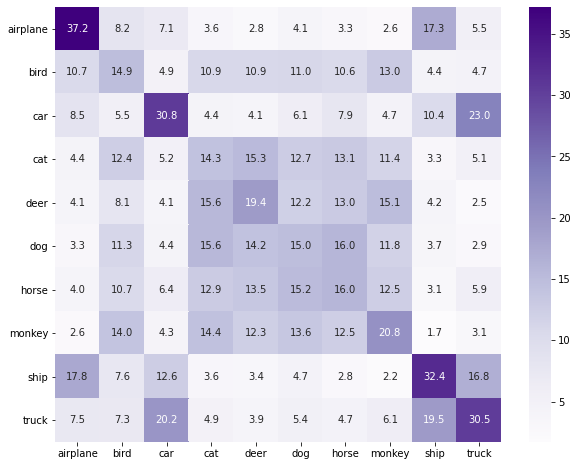

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrices[1]/confusion_matrices[1].sum(axis=0)*100, 
            annot=confusion_matrices[1]/confusion_matrices[1].sum(axis=0)*100, 
            xticklabels=class_names, yticklabels=class_names, fmt='.1f', cmap='Purples')
plt.yticks(rotation=0)